# Everybody Loves Trips

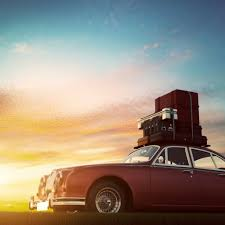

So before the trip starts , we are curious to know where we are going to stay and how good it is :)
So the trip advisor helps us by providing the reviews of the place and helps us getting to know the place better :)

Hotels play a crucial role in traveling and with the increased access to information new pathways of selecting the best ones emerged.
With this dataset, consisting of 20k reviews crawled from Tripadvisor, you can explore what makes a great hotel and maybe even use this model in your travels!

# Importing Packages

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly
import tensorflow as tf
import plotly.graph_objects as go
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer
import copy
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow.keras.layers as L
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
plotly.offline.init_notebook_mode (connected = True)



# Importing all the Required Data

In [ ]:
# Importing the Trip-Advisor-Hotel-Review Dataset
data=pd.read_csv('../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')


# Importing the Sentiment of the Reviews 
score=np.load('../input/score-trip-advisor/score.npy')


# Making a Sentiment Column in the data
data['Sentiment_Score']=score

# This score denoted Postive remark is its higher than 0.5 ; Negative if it's lower than -0.5 and neutral otherwise
score_sentiment=[]
for i in data.Sentiment_Score:
    if i<=-0.5:
        score_sentiment.append('Negative')
    elif i>=0.5:
        score_sentiment.append('Positive')
    else:
        score_sentiment.append('Neutral')
        
        
# Addint the sentiment to the data
data['Sentiment']=score_sentiment


# Having a look at the data
data.head()


## Checking For Null Values

In [ ]:
data.isna().sum()

Wow so we don't have any na values so Let's start

# Visualizations

## Distribution of the sentiment with the Reviews

In [ ]:
sns.countplot(data['Sentiment'])

Ok we see a lot of positive statements :)

Well from this we can see that most of the statements are positive followed by negative and then neutral statements

## Let's see the sentiment distribution with respect to Ratings

In [ ]:
# Grouping the data on the basis on Rating and Sentiment and counting the sentiment score
data2=data.groupby(['Rating','Sentiment'])['Sentiment_Score'].count()


# X here is the Ratings and Y is the Sentiment
X=[i[0] for i in data2.index.values]
Y=[i[1] for i in data2.index.values]

# Plotting the Bar Graph 
fig = px.bar(x=X, y=data2.values, color=Y, title="Sentiment Distribution WRT Ratings",labels={'x':'Ratings','y':'Total Number'})
fig.show()

Ok we can clearly see that the reviews voted 1 are the one's with high number of Negative Reviews which decreases as the ratings of the reviews increases


# Total Ratings distribution in whole data

In [ ]:
# l is the list which has the names of the labels which is 1,2,3,4,5 and y is the count of these labels
l=[]
r=[]
for i in range(1,6):
    l.append(i)
    r.append(len(data[data['Rating']==i]))
    
# Plotting a countplot pie chart for ratings
fig_pie = px.pie(values=r, names=l, title='Rating Distribution of the data')
fig_pie.show()

Most of the people rates there experience with a 5 star ratings :)

## Ratings Vs Sentiment Score

In [ ]:
# Jointplot on the basis of Rating and Sentiment Score of the data
sns.jointplot(data=data,x='Rating',y='Sentiment_Score',kind='reg',color='orange')

### From this we can clearly see the relation between the sentiment score and ratings . As the ratings increases we alse see the sentiment score line to be increasing . We also observe from this data that most of the ratings have a sentiment value in the range of 0.5 - 1 which is a positive sentiment..

# Violin Plot For Ratings and Sentiment Score

In [ ]:
# Violin plot of Rating and Sentiment Score with box plot embedded in it
fig = go.Figure()

Ratings = [1,2,3,4,5]

for rating in Ratings:
    fig.add_trace(go.Violin(x=data['Rating'][data['Rating'] == rating],
                            y=data['Sentiment_Score'][data['Rating'] == rating],
                            name=rating,
                            box_visible=True,
                            meanline_visible=True))

fig.show()

Well this is very informative :)

* Most of the Reviews with Rating 1 has a sentiment score between -1 to 0.5
* Most of the Reviews with the Rating 2 has a sentiment score between 0 to 0.75
* Most of the Reviews with Rating 3 has a sentiment score between 0.8 to 1
* Most of the Reviews with Rating 4 has a sentiment Score between 0.85 to 1
* Most of the Reviews with Rating 5 has a sentiment Score between 0.9 to 1

# Word Cloud For Positive Reviews

In [ ]:
# Getting all the reviews termed positive in a single string and forming a word cloud of the string
text =''
for i in data[data['Sentiment']=='Positive']['Review'].values:
    text+=i + ' '

wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Word Cloud For Negative Reviews


In [ ]:
# Getting all the reviews termed Negative in a single string and forming a word cloud of the string
text =''
for i in data[data['Sentiment']=='Negative']['Review'].values:
    text+=i + ' '
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Word Cloud For Neutral Reviews

In [ ]:
# Getting all the reviews termed Neutral in a single string and forming a word cloud of the string
text =''
for i in data[data['Sentiment']=='Neutral']['Review'].values:
    text+=i + ' '
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Let's Lemmatize and Tokenize The Reviews

Copying Data frame to a new data frame so we can have the original .

In [ ]:
data2=copy.deepcopy(data)

deep copy means any changes made to the copy won't reflect on the original

Since we don't have any nan values in the Review Column we dont need to fill it :)

In [ ]:
# This function is to remove stopwords from a particular column and to tokenize it
def rem_stopwords_tokenize(data,name):
      
    def getting(sen):
        example_sent = sen

        stop_words = set(stopwords.words('english')) 

        word_tokens = word_tokenize(example_sent) 

        filtered_sentence = [w for w in word_tokens if not w in stop_words] 

        filtered_sentence = [] 

        for w in word_tokens: 
            if w not in stop_words: 
                filtered_sentence.append(w) 
        return filtered_sentence
    x=[]
    for i in data[name].values:
        x.append(getting(i))
    data[name]=x

In [ ]:
rem_stopwords_tokenize(data2,'Review')

Now our data don't have any stopwords  :)

## Let's Lemmatize the data now :)

In [ ]:
# Making a function to lemmatize all the words
lemmatizer = WordNetLemmatizer() 
def lemmatize_all(data,name):
    arr=data[name]
    a=[]
    for i in arr:
        b=[]
        for j in i:
            x=lemmatizer.lemmatize(j,pos='n')
            x=lemmatizer.lemmatize(j,pos='v')
            x=lemmatizer.lemmatize(j,pos='a')
            x=lemmatizer.lemmatize(j,pos='r')

            x=lemmatizer.lemmatize(x)
            b.append(x)
        a.append(b)
    data[name]=a

In [ ]:
lemmatize_all(data2,'Review')

Now the reviews are lemmatized too :) 

In [ ]:
# Putting the values of Review column in X variable
X=data2['Review'].values

# Making all the comma seperated lemmatized words back into a string and putting it back to X
sentences=[]
for i in X:
    s=''
    for j in i :
        s+=j+' '
    sentences.append(s)
X=np.array(sentences)

Calling tokenizer and fitting it to the texts

In [ ]:
tokenizer = Tokenizer()


In [ ]:
tokenizer.fit_on_texts(X)

Using tokenizer to convert the text to sequences

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
# Checking the vocabulary size 
vocabulary_size = len(tokenizer.word_index)+1
X=np.array(X)

# Padding the reviews to the length of 600
X = pad_sequences(X, padding='post', maxlen=600)


## Encoding

In [ ]:
encoding = {1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 4
           }

labels = ['1', '2', '3', '4', '5']
           
y = data['Sentiment_Score'].copy()
y.replace(encoding, inplace=True)

# Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.05, random_state=42)

# Model Training On ML

In [ ]:
# hyper parameters
EPOCHS = 10
BATCH_SIZE = 100
embedding_dim = 16
units = 76
model = tf.keras.Sequential([
    L.Embedding(vocabulary_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    #L.LSTM(units,return_sequences=True),
    L.Conv1D(64,3),
    L.MaxPool1D(),
    L.Flatten(),
    L.Dropout(0.5),
    L.Dense(128, activation="relu"),
    L.Dropout(0.5),
    L.Dense(64, activation="relu"),
    L.Dropout(0.5),
    L.Dense(1, activation="relu")
])


In [ ]:
model.compile(loss=MeanAbsoluteError(),
              optimizer='adam',metrics=['MAE']
             )

model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE, verbose=2)


# Accuracy of Train vs Test

In [ ]:
# summarize history for accuracy
plt.plot(history.history['MAE'])
plt.plot(history.history['val_MAE'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss of Train vs Test

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# This model is pretty good as we can predict the score quite good with low loss and Less MAE

# Hope you all liked the file 

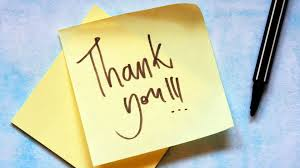